# PocketCoffea: a configuration layer for CMS analysis with Coffea

PocketCoffea is an analysis framework to perform analysis with CMS data in the NanoAOD format with a configuration scheme built on top of the Coffea package. All the usual operations of CMS analyses are shared in a common base code, including the creation of datasets, the application of selection cuts, the event reweighting, the computation of systematic uncertainty and the production of Data/MC plots.
In this tutorial, the main features of the package are presented.
A toy $Z\rightarrow\mu\mu$ analysis is implemented, using the CMS Opendata datasets from the 2012 data at $\sqrt{s}= $ 8 TeV.

**Disclaimer**: For demonstration purposes, we will apply corrections to MC based on the Run-2 datasets to this older datasets.

In [37]:
import os, json
import pocket_coffea

## Define the analysis processor

The core of the analysis is the `processor` object. This is an object defined in `Coffea` and it defines the function that will be called taking all the events as input.

In PocketCoffea, all processors can be derived from an abstract base processor class called `BaseProcessorABC`, that is a `Coffea` processor with a well defined structure:

- **Skim events**: apply lumi mask, triggers and a loose selection to reduce the number of events processed in the following analysis steps
- **Object preselection**: define the "good" object on which will be performed the final analysis
- **Event preselection**: define the baseline selection of the analysis
- **Categorization**: split events passing the preselection into different categories (e.g. signal + control region)
- **Fill histograms** in all categories

For this demo, a dedicated `OpendataBaseProcessor` is implemented in `base_processor.py` to handle the specific structure of the 2012 Opendata CMS files.
A new processor inherited from the `OpendataBaseProcessor` can then be defined to run the $Z\rightarrow\mu\mu$ analysis. We don't need to rewrite the whole analysis processor, but only the methods that we want to override for our specific application.
In this case we just redefine:
- **apply_object_preselection()**: implement the dedicated muon selection
- **define_common_variables_after_presel()**: build the dimuon object and compute its invariant mass
- **count_objects()**: count the "good" objects

In [12]:
import awkward as ak
from coffea.analysis_tools import PackedSelection
from pocket_coffea.utils import utils
from base_processor import OpendataBaseProcessor

class ZmumuBaseProcessor(OpendataBaseProcessor):

    def apply_object_preselection(self, variation):
        '''
        The object preselection cleans the following collections:
          - Muons
        In addition, a dilepton object is built.
        '''
        # Build masks for selection of muons
        cuts = self.params.object_preselection["Muon"]

        # Requirements on pT and eta
        passes_eta = abs(self.events.Muon.eta) < cuts["eta"]
        passes_pt = self.events.Muon.pt > cuts["pt"]
    
        # Requirements on isolation
        passes_iso = self.events.Muon.pfRelIso04_all < cuts["iso"]

        good_muons = passes_eta & passes_pt & passes_iso #& passes_id

        self.events["MuonGood"] = self.events.Muon[good_muons]

    def define_common_variables_after_presel(self, variation):
        self.events["ll"] = self.events.MuonGood[:,0] + self.events.MuonGood[:,1]
        fields = {
            "pt": self.events.ll.pt,
            "eta": self.events.ll.eta,
            "phi": self.events.ll.phi,
            "mass": self.events.ll.mass,
            "charge": self.events.ll.charge,
        }
        self.events["ll"] = ak.zip(fields, with_name="PtEtaPhiMCandidate")

    def count_objects(self, variation):
        self.events["nMuonGood"] = ak.num(self.events.MuonGood)

## Define analysis parameters

The parameters scheme is based on composable YAML parameter files managed with the `OmegaConf` package. A nice set of defaults is defined in `pocket_coffea.parameters.defaults`, containing the most common parameters for a Run-2 CMS analysis. These include the event flags, luminosity, triggers, object preselection, plotting style etc.
The user can then customize the parameters by defining their own parameters in the form of YAML files.
The default parameters can be eventually overridden with custom parameters, thanks to the `merge_parameters_from_files()` function:

In [13]:
from pocket_coffea.parameters import defaults

localdir = os.getcwd()
default_parameters = defaults.get_default_parameters()
parameters = defaults.merge_parameters_from_files(default_parameters,
                                                  f"{localdir}/params/event_flags.yaml",
                                                  f"{localdir}/params/lumi.yaml",
                                                  f"{localdir}/params/object_preselection_semileptonic.yaml",
                                                  f"{localdir}/params/triggers.yaml",
                                                  f"{localdir}/params/plotting_style.yaml",
                                                  update=True)
parameters.keys()

dict_keys(['pileupJSONfiles', 'event_flags', 'event_flags_data', 'lumi', 'default_jets_calibration', 'jets_calibration', 'jet_scale_factors', 'btagging', 'lepton_scale_factors', 'systematic_variations', 'plotting_style', 'object_preselection', 'HLT_triggers'])

In [14]:
parameters

{'pileupJSONfiles': {'2016_PreVFP': {'file': '/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/LUM/2016preVFP_UL/puWeights.json.gz', 'name': 'Collisions16_UltraLegacy_goldenJSON'}, '2016_PostVFP': {'file': '/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/LUM/2016postVFP_UL/puWeights.json.gz', 'name': 'Collisions16_UltraLegacy_goldenJSON'}, '2017': {'file': '/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/LUM/2017_UL/puWeights.json.gz', 'name': 'Collisions17_UltraLegacy_goldenJSON'}, '2018': {'file': '/cvmfs/cms.cern.ch/rsync/cms-nanoAOD/jsonpog-integration/POG/LUM/2018_UL/puWeights.json.gz', 'name': 'Collisions18_UltraLegacy_goldenJSON'}}, 'event_flags': {'2018': ['goodVertices', 'globalSuperTightHalo2016Filter', 'HBHENoiseFilter', 'HBHENoiseIsoFilter', 'EcalDeadCellTriggerPrimitiveFilter', 'BadPFMuonFilter'], '2017': ['goodVertices', 'globalSuperTightHalo2016Filter', 'HBHENoiseFilter', 'HBHENoiseIsoFilter', 'EcalDeadCellTriggerPrimitiveFilter', 'B

## Define datasets

A dictionary containing the datasets information is passed to the `Configurator`. This includes the list of json datasets, together with a dictionary to filter the datasets by the sample key or by year. At this point it is also possible to define **subsamples**, i.e. split samples into different subsets (e.g. split data by the trigger path or split a MC sample into distinct components).

In [40]:
from pocket_coffea.lib.cut_functions import get_nObj_eq

datasets = {
    "jsons": [f"{localdir}/datasets/DYJetsToLL_local.json",
              f"{localdir}/datasets/DATA_DoubleMuon_local.json"],
    "filter" : {
        "samples": ["DYJetsToLL",
                    "DATA_DoubleMuon"
                   ],
        "samples_exclude" : [],
        "year": ["2012"]
    },
    "subsamples" : {
        'DYJetsToLL'  : {
            'DYJetsToLL_2mu' : [get_nObj_eq(2, coll="MuonGood")],
            'DYJetsToLL_3mu' : [get_nObj_eq(3, coll="MuonGood")],
            'DYJetsToLL_>=4mu' : [get_nObj_min(4, coll="MuonGood")],
        },
    },
}

d = json.load(open(f"{localdir}/datasets/DATA_DoubleMuon.json", 'r'))
d.keys()

dict_keys(['DATA_DoubleMuon_2012', 'DATA_DoubleMuon_2017_EraB', 'DATA_DoubleMuon_2017_EraC', 'DATA_DoubleMuon_2017_EraD', 'DATA_DoubleMuon_2017_EraE', 'DATA_DoubleMuon_2017_EraF', 'DATA_DoubleMuon_2017_EraG'])

## Skim, preselection and categorization

All the selection operations are performed by making use of `Cut` objects. These objects are defined by a function of the events and a set of parameters. This way, for a given function we can have multiple cuts by changing the parameters that we pass to the `Cut` constructor.
Below is an example of a cut function `dimuon()` that is used to build a `Cut` object named `dimuon_presel`:

In [16]:
from pocket_coffea.lib.cut_definition import Cut
from pocket_coffea.lib.cut_functions import get_nObj_min, get_HLTsel
from pocket_coffea.parameters.cuts import passthrough

def dimuon(events, params, year, sample, **kwargs):

    # Masks for same-flavor (SF) and opposite-sign (OS)
    SF = events.nMuonGood == 2
    OS = events.ll.charge == 0

    mask = (
        (events.nMuonGood == 2)
        & (ak.firsts(events.MuonGood.pt) > params["pt_leading_muon"])
        & OS & SF
        & (events.ll.mass > params["mll"]["low"])
        & (events.ll.mass < params["mll"]["high"])
    )

    # Pad None values with False
    return ak.where(ak.is_none(mask), False, mask)

SR_selection = Cut(
    name="SR",
    params={
        "pt_leading_muon": 25,
        "mll": {'low': 75, 'high': 115},
    },
    function=dimuon,
)

CR_selection_low_mll = Cut(
    name="CR",
    params={
        "pt_leading_muon": 25,
        "mll": {'low': 25, 'high': 75},
    },
    function=dimuon,
)

CR_selection_high_mll = Cut(
    name="CR",
    params={
        "pt_leading_muon": 25,
        "mll": {'low': 1155, 'high': 2000},
    },
    function=dimuon,
)

## Weights and systematic variations

Another important ingredient of our analyses is the application of correction to the MC simulation and the proper accounting of systematic uncertainties. In PocketCoffea, a dedicated module `WeightsManager` is handling the application of weights to MC. In the configuration file, the user just needs to list the names of the correction weights to apply and the systematic variations that have to be stored in the output histograms.

In [17]:
weights = {
    "common": {
        "inclusive": ["genWeight","lumi","XS",
                      #"pileup",
                      #"sf_ele_reco", "sf_ele_id",
                      #"sf_mu_id","sf_mu_iso",
                      ],
        "bycategory" : {
        }
    },
    "bysample": {
    }
}

variations = {
    "weights": {
        "common": {
            "inclusive": [ ],#"pileup" ],
            "bycategory" : {
            }
        },
        "bysample": {
        }
    },
    "shape": {
        "common":{
            "inclusive": [ ]
        }
    }
}

## Load Configurator

The core of the configuration is the `Configurator` object that stores all the datasets, parameters, selections and histograms configuration. The configuration can be dumped as a human readable .json file and as a .pkl file so that the same configuration can be loaded to rerun the same analysis in the future. The parameters are also dumped in a .yaml file to store all the parameters that define the analysis.

In [18]:
from pocket_coffea.utils.configurator import Configurator
from pocket_coffea.parameters.histograms import muon_hists
from pocket_coffea.lib.hist_manager import HistConf, Axis
from base_processor import ZmumuBaseProcessor

cfg = Configurator(
    parameters=parameters,
    datasets=datasets,
    workflow=ZmumuBaseProcessor,
    skim = [get_nObj_min(2, 15., "Muon"),
            get_HLTsel(primaryDatasets=["DoubleMuon"])],
    preselections = [get_nObj_min(2, 25., "MuonGood")],
    categories = {
        "inclusive" : [passthrough],
        "mll_75To115" : [SR_selection],
        "mll_25To75" : [CR_selection_low_mll],
        "mll_75ToInf" : [CR_selection_high_mll],
    },
    weights = weights,
    variations = variations,
    variables = {
        **muon_hists(coll="MuonGood"),
        **muon_hists(coll="MuonGood", pos=0),
        "mll" : HistConf( [Axis(coll="ll", field="mass", bins=100, start=0, stop=200, label=r"$M_{\mu\mu}$ [GeV]")] ),
    }
)
output_dir = "output"
cfg.save_config(output_dir)

Saving config file to output/config.json


In [19]:
from pocket_coffea.utils.run import IterativeRunner, FuturesRunner

print(f"Available CPUs = {os.cpu_count()}")

run_options = {
    "executor"       : "local",
    "env"            : "conda",
    "workers"        : 1,
    "scaleout"       : 32,
    "worker_image"   : "/cvmfs/unpacked.cern.ch/gitlab-registry.cern.ch/cms-analysis/general/pocketcoffea:lxplus-cc7-latest",
    "queue"          : "standard",
    "walltime"       : "02:00:00",
    "mem_per_worker" : "4GB", # GB
    "disk_per_worker" : "1GB", # GB
    "exclusive"      : False,
    "chunk"          : 200000,
    "retries"        : 50,
    "treereduction"  : 20,
    "adapt"          : False,
    "voms"           : ""
}
runner = FuturesRunner(architecture="local", run_options=run_options, output_dir=output_dir, loglevel="INFO")
runner

Available CPUs = 72


In [20]:
runner.run(
    cfg.filesets,
    cfg.processor_instance,
    full=True,
)

[INFO    ] Working on samples: ['DYJetsToLL_2012', 'DATA_DoubleMuon_2012']
[INFO    ] Working on samples: ['DYJetsToLL_2012', 'DATA_DoubleMuon_2012']


Output()

/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_jetIdx => Jet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference

The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuonThe skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon

The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applie

/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon


The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuonThe skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_jetIdx => Jet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
 

The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_jetIdx => Jet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference

The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_jetIdx => Jet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_jetIdx => Jet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference inde

The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_jetIdx => Jet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference

The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon

/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Muon_jetIdx => Jet
  warnings.warn(


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Jet_muonIdx2 => Muon
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Photon_electronIdx => Electron
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Muon_fsrPhotonIdx => FsrPhoton
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Photon_jetIdx => Jet
  warnings.warn(


The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon

/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Muon_jetIdx => Jet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Tau_jetIdx => Jet
  warnings.warn(


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Photon_electronIdx => Electron
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Photon_jetIdx => Jet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Tau_jetIdx => Jet
  warnings.warn(


The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_jetIdx => Jet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference

The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_jetIdx => Jet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_su

The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon

/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Muon_fsrPhotonIdx => FsrPhoton
  warnings.warn(


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Muon_jetIdx => Jet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_jetIdx => Jet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Photon_electronIdx => Electron
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index

The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon

/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_jetIdx => Jet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Photon_electronIdx => Electron
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Jet_muonIdx2 => Muon
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Muon_fsrPhotonIdx => FsrPhoton
  warnings.warn(


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Photon_jetIdx => Jet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Muon_fsrPhotonIdx => FsrPhoton
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Muon_jetIdx => Jet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index f

The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon

/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Jet_electronIdx2 => Electron
  warnings.warn(



The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon

/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Jet_muonIdx1 => Muon
  warnings.warn(


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Jet_muonIdx2 => Muon
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_jetIdx => Jet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Muon_fsrPhotonIdx => FsrPhoton
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference ind

The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon

/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Jet_electronIdx2 => Electron
  warnings.warn(



The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon

/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Jet_muonIdx1 => Muon
  warnings.warn(


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Jet_muonIdx2 => Muon
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Muon_fsrPhotonIdx => FsrPhoton
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Muon_jetIdx => Jet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Photon_electronIdx => Electron
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index

The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_jetIdx => Jet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference

The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuonThe skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon

The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_jetIdx => Jet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(


The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon

/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FsrPhoton_muonIdx => Muon
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Jet_electronIdx1 => Electron
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Jet_electronIdx2 => Electron
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-refer

The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon

/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_jetIdx => Jet
  warnings.warn(


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_photonIdx => Photon
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx1 => SubJet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_subJetIdx2 => SubJet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_jetIdx => Jet
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference

The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applie

/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applie

/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuonThe skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon



The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(


The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon
The skim function HLT_trigger_DoubleMuon is not applied to the sample DATA_DoubleMuon


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for Electron_genPartIdx => GenPart
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for GenPart_genPartIdxMother => GenPart
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWarning: Missing cross-reference index for GenVisTau_genPartIdxMother => GenPart
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/coffea/nanoevents/schemas/nanoaod.py:201: RuntimeWa

Saving output to output/output_all.coffea


In [21]:
os.listdir(output_dir)

['parameters_dump.yaml',
 'configurator.pkl',
 'output_all.coffea',
 'config.json']

## Output

In [23]:
from coffea.util import load
o = load("output/output_all.coffea")
o.keys()

dict_keys(['sum_genweights', 'sumw', 'cutflow', 'variables', 'columns', 'processing_metadata', 'datasets_metadata'])

## Produce Data/MC plots

In [24]:
from pocket_coffea.utils.plot_utils import PlotManager, Shape

In [25]:
plotter = PlotManager(
    variables=o["variables"].keys(),
    hist_objs=o["variables"],
    datasets_metadata=o['datasets_metadata'],
    plot_dir="plots",
    style_cfg=parameters['plotting_style'],
    only_cat=None,
    workers=8,
    log=False,
    density=False,
    save=False,
    toplabel="4.41 $fb^{-1}$, $\sqrt{s}=$8 TeV, 2012 C"
)
plotter

In [26]:
plotter.shape_objects

{'MuonGood_eta_2012': <pocket_coffea.utils.plot_utils.Shape at 0x7f16c6b7ea30>,
 'MuonGood_pt_2012': <pocket_coffea.utils.plot_utils.Shape at 0x7f16c6a06910>,
 'MuonGood_phi_2012': <pocket_coffea.utils.plot_utils.Shape at 0x7f16c68db280>,
 'MuonGood_eta_1_2012': <pocket_coffea.utils.plot_utils.Shape at 0x7f16c67ef250>,
 'MuonGood_pt_1_2012': <pocket_coffea.utils.plot_utils.Shape at 0x7f16c848f4f0>,
 'MuonGood_phi_1_2012': <pocket_coffea.utils.plot_utils.Shape at 0x7f16cda43940>,
 'mll_2012': <pocket_coffea.utils.plot_utils.Shape at 0x7f16c7d9ac10>}

In [27]:
shape = plotter.shape_objects["mll_2012"]
shape.plot_datamc?

Signature: shape.plot_datamc(cat, ratio=True, syst=True, ax=None, rax=None)
Docstring:
Plots the data histogram as an errorbar plot on top of the MC stacked histograms.
If ratio is True, also the Data/MC ratio plot is plotted.
If syst is True, also the total systematic uncertainty is plotted.
File:      /work/mmarcheg/PocketCoffea/pocket_coffea/utils/plot_utils.py
Type:      method

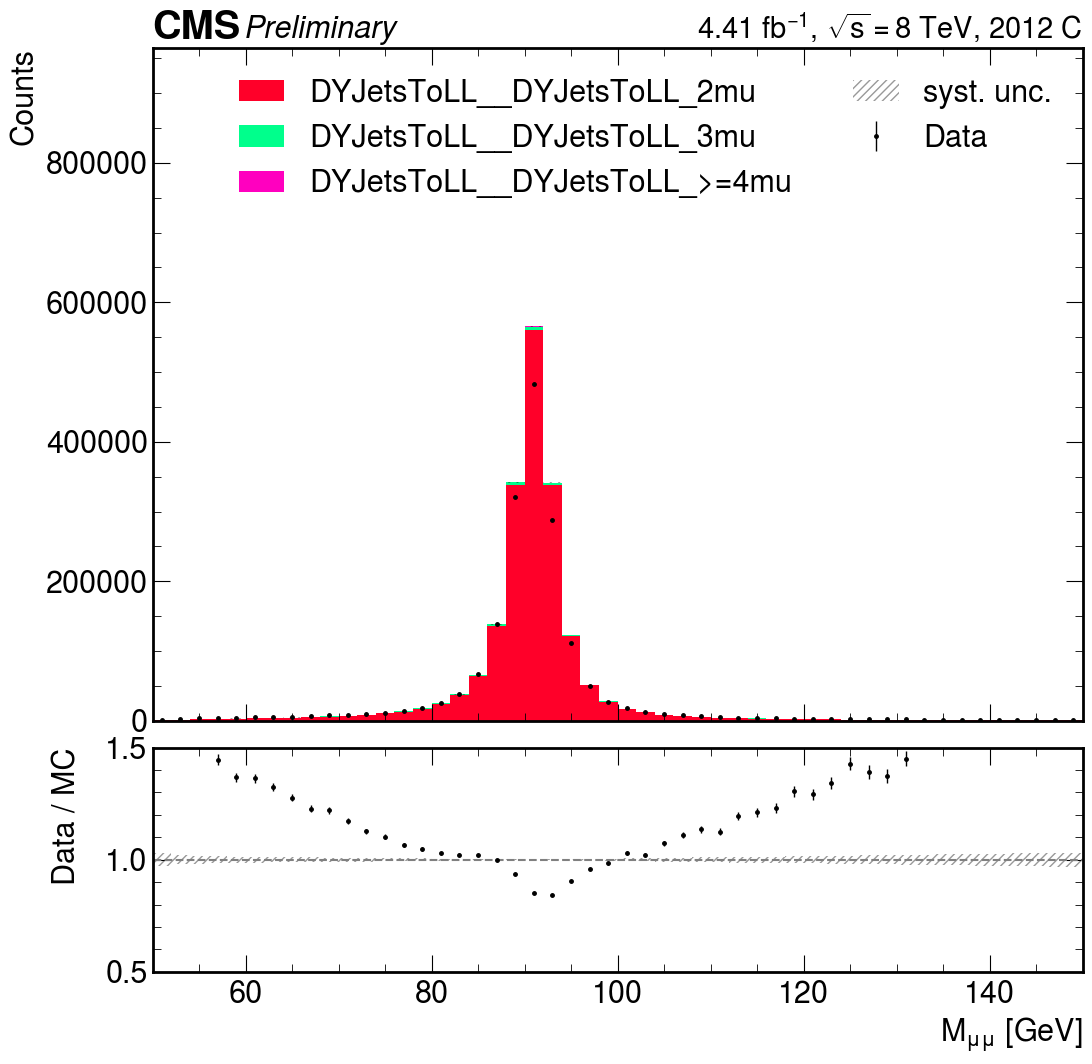

In [36]:
fig, (ax, rax) = shape.define_figure(ratio=True)
shape.plot_datamc("inclusive")
ax.set_xlim(50, 150);

## Fetch the dataset from DAS and rucio

In [15]:
from pocket_coffea.utils.dataset import build_datasets
build_datasets(
    "datasets/datasets_definitions.json",
    overwrite=True,
    #local_prefix=self.local_prefix,
    #whitelist_sites=self.whitelist_sites,
    #blacklist_sites=self.blacklist_sites,
    #regex_sites=self.regex_sites,
    parallelize=4,
)

****************************************************************************************************************************************************************



> Working on dataset: > Working on dataset: > Working on dataset: > Working on dataset:     DATA_SingleEleDATA_DoubleMuonTTbbSemiLeptonic_4f
TTTo2L2Nu


>> Query for sample: DATA_SingleEle,  das_name: ['/SingleElectron/Run2016B-ver1_HIPM_UL2016_MiniAODv2_NanoAODv9-v2/NANOAOD', '/SingleElectron/Run2016B-ver2_HIPM_UL2016_MiniAODv2_NanoAODv9-v2/NANOAOD']
>> Query for sample: DATA_DoubleMu,  das_name: ['/DoubleMuon/Run2017B-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD']>> Query for sample: TTTo2L2Nu,  das_name: ['/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL16NanoAODAPVv9-106X_mcRun2_asymptotic_preVFP_v11-v1/NANOAODSIM']>> Query for sample: TTbbSemiLeptonic,  das_name: ['/TTbb_4f_TTToSemiLeptonic_TuneCP5-Powheg-Openloops-Pythia8/RunIISummer20UL16NanoAODAPVv9-106X_mcRun2_asymptotic_preVFP_v11-v1/NANOAODSIM']


dict_keys(['DATA

/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.

>> Query for sample: TTbbSemiLeptonic,  das_name: ['/TTbb_4f_TTToSemiLeptonic_TuneCP5-Powheg-Openloops-Pythia8/RunIISummer20UL16NanoAODv9-106X_mcRun2_asymptotic_v17-v1/NANOAODSIM']
>> Query for sample: TTTo2L2Nu,  das_name: ['/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL16NanoAODv9-106X_mcRun2_asymptotic_v17-v1/NANOAODSIM']
>> Query for sample: DATA_DoubleMu,  das_name: ['/DoubleMuon/Run2017C-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.

>> Query for sample: TTbbSemiLeptonic,  das_name: ['/TTbb_4f_TTToSemiLeptonic_TuneCP5-Powheg-Openloops-Pythia8/RunIISummer20UL17NanoAODv9-106X_mc2017_realistic_v9-v1/NANOAODSIM']
>> Query for sample: DATA_DoubleMu,  das_name: ['/DoubleMuon/Run2017D-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD']
>> Query for sample: DATA_SingleEle,  das_name: ['/SingleElectron/Run2016C-HIPM_UL2016_MiniAODv2_NanoAODv9-v2/NANOAOD']
>> Query for sample: TTTo2L2Nu,  das_name: ['/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL17NanoAODv9-106X_mc2017_realistic_v9-v1/NANOAODSIM']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.

>> Query for sample: TTbbSemiLeptonic,  das_name: ['/TTbb_4f_TTToSemiLeptonic_TuneCP5-Powheg-Openloops-Pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM']
>> Query for sample: DATA_SingleEle,  das_name: ['/SingleElectron/Run2016D-HIPM_UL2016_MiniAODv2_NanoAODv9-v2/NANOAOD']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


>> Query for sample: DATA_DoubleMu,  das_name: ['/DoubleMuon/Run2017E-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD']
>> Query for sample: TTTo2L2Nu,  das_name: ['/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.

****************************************
> Working on dataset:  TTToSemiLeptonic
>> Query for sample: TTToSemiLeptonic,  das_name: ['/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL16NanoAODAPVv9-106X_mcRun2_asymptotic_preVFP_v11-v1/NANOAODSIM']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


>> Query for sample: DATA_DoubleMu,  das_name: ['/DoubleMuon/Run2017F-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD']
>> Query for sample: DATA_SingleEle,  das_name: ['/SingleElectron/Run2016E-HIPM_UL2016_MiniAODv2_NanoAODv9-v2/NANOAOD']
****************************************
> Working on dataset:  ST_s-channel_4f_leptonDecays
>> Query for sample: SingleTop,  das_name: ['/ST_s-channel_4f_leptonDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL17NanoAODv9-106X_mc2017_realistic_v9-v1/NANOAODSIM']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.

>> Query for sample: TTToSemiLeptonic,  das_name: ['/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL16NanoAODv9-106X_mcRun2_asymptotic_v17-v1/NANOAODSIM']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


>> Query for sample: DATA_DoubleMu,  das_name: ['/DoubleMuon/Run2017G-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD']
>> Query for sample: SingleTop,  das_name: ['/ST_s-channel_4f_leptonDecays_TuneCP5_13TeV-amcatnlo-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM']
>> Query for sample: DATA_SingleEle,  das_name: ['/SingleElectron/Run2016F-HIPM_UL2016_MiniAODv2_NanoAODv9-v2/NANOAOD']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.

>> Query for sample: TTToSemiLeptonic,  das_name: ['/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL17NanoAODv9-106X_mc2017_realistic_v9-v1/NANOAODSIM']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


****************************************
> Working on dataset:  ST_t-channel_top_4f_InclusiveDecays
>> Query for sample: SingleTop,  das_name: ['/ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL17NanoAODv9-106X_mc2017_realistic_v9-v1/NANOAODSIM']
****************************************
> Working on dataset:  DATA_SingleMuon
>> Query for sample: DATA_SingleMuon,  das_name: ['/SingleMuon/Run2016B-ver1_HIPM_UL2016_MiniAODv2_NanoAODv9-v2/NANOAOD', '/SingleMuon/Run2016B-ver2_HIPM_UL2016_MiniAODv2_NanoAODv9-v2/NANOAOD']
>> Query for sample: DATA_SingleEle,  das_name: ['/SingleElectron/Run2016F-UL2016_MiniAODv2_NanoAODv9-v1/NANOAOD']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.

>> Query for sample: TTToSemiLeptonic,  das_name: ['/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM']
>> Query for sample: DATA_SingleEle,  das_name: ['/SingleElectron/Run2016G-UL2016_MiniAODv2_NanoAODv9-v1/NANOAOD']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


>> Query for sample: SingleTop,  das_name: ['/ST_t-channel_top_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.

>> Query for sample: DATA_SingleMuon,  das_name: ['/SingleMuon/Run2016C-HIPM_UL2016_MiniAODv2_NanoAODv9-v2/NANOAOD']
>> Query for sample: DATA_SingleEle,  das_name: ['/SingleElectron/Run2016H-UL2016_MiniAODv2_NanoAODv9-v1/NANOAOD']
****************************************
> Working on dataset:  ST_t-channel_antitop_4f_InclusiveDecays
>> Query for sample: SingleTop,  das_name: ['/ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL17NanoAODv9-106X_mc2017_realistic_v9-v1/NANOAODSIM']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.

>> Query for sample: DATA_SingleMuon,  das_name: ['/SingleMuon/Run2016D-HIPM_UL2016_MiniAODv2_NanoAODv9-v2/NANOAOD']
>> Query for sample: DATA_SingleEle,  das_name: ['/SingleElectron/Run2017B-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD']
****************************************
> Working on dataset:  ST_tW_top_5f_NoFullyHadronicDecays
>> Query for sample: SingleTop,  das_name: ['/ST_tW_top_5f_NoFullyHadronicDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL17NanoAODv9-106X_mc2017_realistic_v9-v1/NANOAODSIM']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


>> Query for sample: SingleTop,  das_name: ['/ST_t-channel_antitop_4f_InclusiveDecays_TuneCP5_13TeV-powheg-madspin-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.

>> Query for sample: DATA_SingleMuon,  das_name: ['/SingleMuon/Run2016E-HIPM_UL2016_MiniAODv2_NanoAODv9-v2/NANOAOD']
>> Query for sample: DATA_SingleEle,  das_name: ['/SingleElectron/Run2017C-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD']
>> Query for sample: SingleTop,  das_name: ['/ST_tW_top_5f_NoFullyHadronicDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


****************************************
> Working on dataset:  WJetsToLNu_HT-70To100
>> Query for sample: WJetsToLNu_HT,  das_name: ['/WJetsToLNu_HT-70To100_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL17NanoAODv9-106X_mc2017_realistic_v9-v1/NANOAODSIM']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.

>> Query for sample: DATA_SingleMuon,  das_name: ['/SingleMuon/Run2016F-HIPM_UL2016_MiniAODv2_NanoAODv9-v2/NANOAOD']
>> Query for sample: DATA_SingleEle,  das_name: ['/SingleElectron/Run2017D-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD']
****************************************
> Working on dataset:  ST_tW_antitop_5f_NoFullyHadronicDecays
>> Query for sample: SingleTop,  das_name: ['/ST_tW_antitop_5f_NoFullyHadronicDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL17NanoAODv9-106X_mc2017_realistic_v9-v1/NANOAODSIM']
>> Query for sample: WJetsToLNu_HT,  das_name: ['/WJetsToLNu_HT-70To100_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.

>> Query for sample: SingleTop,  das_name: ['/ST_tW_antitop_5f_NoFullyHadronicDecays_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM']
>> Query for sample: DATA_SingleEle,  das_name: ['/SingleElectron/Run2017E-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD']
>> Query for sample: DATA_SingleMuon,  das_name: ['/SingleMuon/Run2016F-UL2016_MiniAODv2_NanoAODv9-v1/NANOAOD']
****************************************
> Working on dataset:  WJetsToLNu_HT-100To200
>> Query for sample: WJetsToLNu_HT,  das_name: ['/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL17NanoAODv9-106X_mc2017_realistic_v9-v1/NANOAODSIM']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.

****************************************
> Working on dataset:  WJetsToLNu_HT-200To400
>> Query for sample: WJetsToLNu_HT,  das_name: ['/WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL17NanoAODv9-106X_mc2017_realistic_v9-v1/NANOAODSIM']
>> Query for sample: DATA_SingleMuon,  das_name: ['/SingleMuon/Run2016G-UL2016_MiniAODv2_NanoAODv9-v1/NANOAOD']
>> Query for sample: DATA_SingleEle,  das_name: ['/SingleElectron/Run2017F-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


>> Query for sample: WJetsToLNu_HT,  das_name: ['/WJetsToLNu_HT-100To200_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.

>> Query for sample: WJetsToLNu_HT,  das_name: ['/WJetsToLNu_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM']
>> Query for sample: DATA_SingleMuon,  das_name: ['/SingleMuon/Run2016H-UL2016_MiniAODv2_NanoAODv9-v1/NANOAOD']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


>> Query for sample: DATA_SingleEle,  das_name: ['/EGamma/Run2018A-UL2018_MiniAODv2_NanoAODv9_GT36-v1/NANOAOD']
****************************************
> Working on dataset:  WJetsToLNu_HT-600To800
>> Query for sample: WJetsToLNu_HT,  das_name: ['/WJetsToLNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL17NanoAODv9-106X_mc2017_realistic_v9-v1/NANOAODSIM']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.

****************************************
> Working on dataset:  WJetsToLNu_HT-400To600
>> Query for sample: WJetsToLNu_HT,  das_name: ['/WJetsToLNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL17NanoAODv9-106X_mc2017_realistic_v9-v1/NANOAODSIM']
>> Query for sample: WJetsToLNu_HT,  das_name: ['/WJetsToLNu_HT-600To800_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


>> Query for sample: DATA_SingleMuon,  das_name: ['/SingleMuon/Run2017B-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


>> Query for sample: DATA_SingleEle,  das_name: ['/EGamma/Run2018B-UL2018_MiniAODv2_NanoAODv9_GT36-v1/NANOAOD']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


>> Query for sample: WJetsToLNu_HT,  das_name: ['/WJetsToLNu_HT-400To600_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM']
****************************************
> Working on dataset:  WJetsToLNu_HT-800To1200
>> Query for sample: WJetsToLNu_HT,  das_name: ['/WJetsToLNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL17NanoAODv9-106X_mc2017_realistic_v9-v3/NANOAODSIM']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


>> Query for sample: DATA_SingleMuon,  das_name: ['/SingleMuon/Run2017C-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


>> Query for sample: DATA_SingleEle,  das_name: ['/EGamma/Run2018C-UL2018_MiniAODv2_NanoAODv9_GT36-v1/NANOAOD']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


****************************************
> Working on dataset:  WJetsToLNu_HT-1200To2500
>> Query for sample: WJetsToLNu_HT,  das_name: ['/WJetsToLNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL17NanoAODv9-106X_mc2017_realistic_v9-v1/NANOAODSIM']
>> Query for sample: WJetsToLNu_HT,  das_name: ['/WJetsToLNu_HT-800To1200_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


>> Query for sample: DATA_SingleMuon,  das_name: ['/SingleMuon/Run2017D-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD']
>> Query for sample: DATA_SingleEle,  das_name: ['/EGamma/Run2018D-UL2018_MiniAODv2_NanoAODv9-v3/NANOAOD']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


>> Query for sample: WJetsToLNu_HT,  das_name: ['/WJetsToLNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v1/NANOAODSIM']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


>> Query for sample: DATA_SingleMuon,  das_name: ['/SingleMuon/Run2017E-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD']
****************************************
> Working on dataset:  WJetsToLNu_HT-2500ToInf
>> Query for sample: WJetsToLNu_HT,  das_name: ['/WJetsToLNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL17NanoAODv9-106X_mc2017_realistic_v9-v2/NANOAODSIM']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


>> Query for sample: DATA_SingleMuon,  das_name: ['/SingleMuon/Run2017F-UL2017_MiniAODv2_NanoAODv9-v1/NANOAOD']>> Query for sample: WJetsToLNu_HT,  das_name: ['/WJetsToLNu_HT-2500ToInf_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2/NANOAODSIM']

****************************************
> Working on dataset:  ttHTobb
>> Query for sample: ttHTobb,  das_name: ['/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL17NanoAODv9-106X_mc2017_realistic_v9-v2/NANOAODSIM']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.

>> Query for sample: ttHTobb,  das_name: ['/ttHTobb_M125_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18NanoAODv9-106X_upgrade2018_realistic_v16_L1v1-v2/NANOAODSIM']
>> Query for sample: DATA_SingleMuon,  das_name: ['/SingleMuon/Run2018A-UL2018_MiniAODv2_NanoAODv9-v2/NANOAOD']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


>> Query for sample: DATA_SingleMuon,  das_name: ['/SingleMuon/Run2018B-UL2018_MiniAODv2_NanoAODv9-v2/NANOAOD']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


>> Query for sample: DATA_SingleMuon,  das_name: ['/SingleMuon/Run2018C-UL2018_MiniAODv2_NanoAODv9-v2/NANOAOD']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


>> Query for sample: DATA_SingleMuon,  das_name: ['/SingleMuon/Run2018D-UL2018_MiniAODv2_NanoAODv9-v1/NANOAOD']


/t3home/mmarcheg/micromamba/envs/pocket-coffea/lib/python3.9/site-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cmsweb.cern.ch'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Saving datasets DATA_DoubleMuon to datasets/DATA_DoubleMuon.json
Saving datasets DATA_DoubleMuon to datasets/DATA_DoubleMuon_redirector.json
Saving datasets DATA_SingleMuon to datasets/DATA_SingleMuon.json
Saving datasets DATA_SingleMuon to datasets/DATA_SingleMuon_redirector.json
Saving datasets DATA_SingleEle to datasets/DATA_SingleEle.json
Saving datasets DATA_SingleEle to datasets/DATA_SingleEle_redirector.json
Saving datasets ttHTobb to datasets/signal_ttHTobb.json
Saving datasets ttHTobb to datasets/signal_ttHTobb_redirector.json
Saving datasets TTbbSemiLeptonic_4f to datasets/backgrounds_MC_TTbb.json
Saving datasets TTbbSemiLeptonic_4f to datasets/backgrounds_MC_TTbb_redirector.json
Saving datasets TTToSemiLeptonic to datasets/backgrounds_MC_ttbar.json
Saving datasets TTToSemiLeptonic to datasets/backgrounds_MC_ttbar_redirector.json
Saving datasets TTTo2L2Nu to datasets/backgrounds_MC_ttbar.json
Saving datasets TTTo2L2Nu to datasets/backgrounds_MC_ttbar_redirector.json
Saving da